# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [292]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import pyspark.sql.functions as F
from pyspark.sql.window import Window
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import re

In [11]:
# create a Spark session
spark = SparkSession.builder.appName('sparkify').getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

## Load Data

In [374]:
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

In [29]:
user_log.take(3)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30'),
 Row(artist='Five Iron Frenzy', auth='Logged In', firstName='Micah', gender='M', itemInSession=79, lastName='Long', length=236.09424, level='free', location='Boston-Cambridge-Newton, MA-NH', method='PUT', page='NextSong', registration=1538331630000, sessionId=8, song='Canada', status=200, ts=1538352180000, userAgent='"Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/37.0.2062.103 Safari/537.36"', userId='9'),
 Row(artist='Adam Lambert', auth='Logged In', firstName='Colin', gender='M', itemInSession=51, lastName='Freeman', length=282.8273, level='paid', location='

## Data Types

In [31]:
user_log.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [375]:
user_log.filter('userid not rlike "[0-9]+"').select('userid').dropDuplicates().collect()

[Row(userid='')]

In [33]:
user_log.filter(user_log.userId == "").select('auth').dropDuplicates().collect()

[Row(auth='Logged Out'), Row(auth='Guest')]

In [376]:
user_log = user_log.withColumn("userId", user_log["userId"].cast(types.IntegerType()))

All columns have appropriate data types, except the `userId` column. I convert the variable from string to integer. By doing so, empty strings (as used for events from unregistered users) will become missing values.

## Missing values

In [35]:
def count_missing_values(df):
    """ Counts missing values for each column of df """
    
    missings = df.select([
        F.count(F.when(F.isnull(col) | F.isnan(col), 1)).alias(col) for col in df.columns
    ])
    
    return missings

In [36]:
print(count_missing_values(user_log).collect())

[Row(artist=58392, auth=0, firstName=8346, gender=8346, itemInSession=0, lastName=8346, length=58392, level=0, location=8346, method=0, page=0, registration=8346, sessionId=0, song=58392, status=0, ts=0, userAgent=8346, userId=8346)]


In [37]:
cond1 = (user_log.userId.isNotNull())
print(count_missing_values(user_log.filter(cond1)).collect())

[Row(artist=50046, auth=0, firstName=0, gender=0, itemInSession=0, lastName=0, length=50046, level=0, location=0, method=0, page=0, registration=0, sessionId=0, song=50046, status=0, ts=0, userAgent=0, userId=0)]


In [38]:
cond2 = (user_log.page == "NextSong")
print(count_missing_values(user_log.filter(cond1 & cond2)).collect())

[Row(artist=0, auth=0, firstName=0, gender=0, itemInSession=0, lastName=0, length=0, level=0, location=0, method=0, page=0, registration=0, sessionId=0, song=0, status=0, ts=0, userAgent=0, userId=0)]


There seems to be no major issue with missing values. Missing values occur in user specific variables (`firstName`, `gender`, `lastName`, `location`, `registration`, `userAgent`) only for events of unregistered users (for which holds `userId == None`), as well as in song specific variables (`artist`, `length`, `song`) for not song-related events (for which holds `page != "NextSong"`). 

In [377]:
user_log = user_log.filter(user_log.userId.isNotNull())

Since we are only interested in the behavior of registered users for the purpose of churn prediction, I will drop events of unregistered users for the further analysis.

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [147]:
user_log.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

In [176]:
# Number of unique values per column
def count_unique(df, col):
    """ Counts number of unique values of col in df """

    return df.select(col).dropDuplicates().count()

cols = ['userId', 'sessionId', 'location', 'artist', 'song']
print("Number of unique values per column:")
for col in cols:
    print("{0:<10}: {1:>10}".format(col, count_unique(user_log, col)))

Number of unique values per column:
userId    :        225
sessionId :       2312
location  :        114
artist    :      17656
song      :      58481


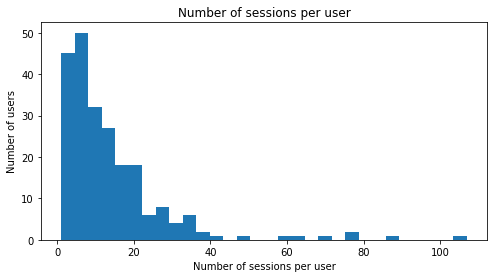

In [197]:
# Number of sessions per user
num_sessions_per_user = user_log.groupBy('userId').agg(F.countDistinct('sessionId').alias('num_sessions')).toPandas()
plt.figure(figsize=(8, 4))
plt.title("Number of sessions per user")
num_sessions_per_user['num_sessions'].hist(bins=30)
plt.xlabel("Number of sessions per user")
plt.ylabel("Number of users")
plt.grid(None)
plt.show()

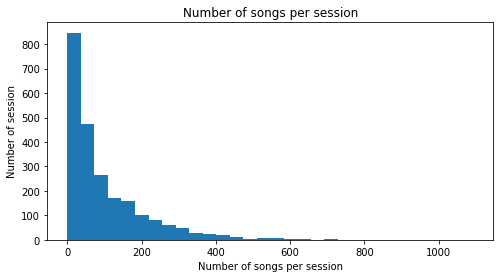

In [198]:
# Number of songs per session
num_songs_per_session = user_log.groupBy('sessionId').agg(F.sum(F.when(F.col('page') == 'NextSong', 1).otherwise(0)).alias('num_songs')).toPandas()
plt.figure(figsize=(8, 4))
plt.title("Number of songs per session")
num_songs_per_session['num_songs'].hist(bins=30)
plt.xlabel("Number of songs per session")
plt.ylabel("Number of session")
plt.grid(None)
plt.show()

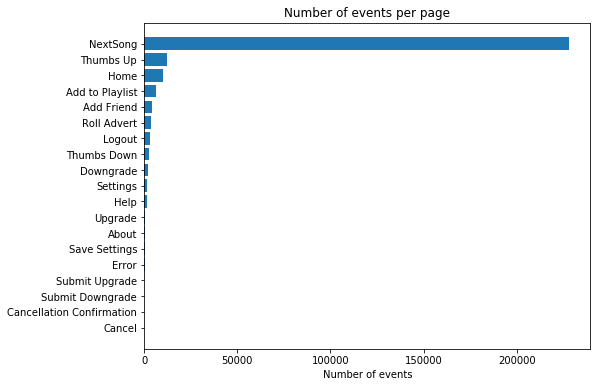

In [200]:
# Pages
num_events_per_page = user_log.groupBy('page').count().toPandas().sort_values('count')
plt.figure(figsize=(8, 6))
plt.title("Number of events per page")
plt.barh(num_events_per_page['page'], num_events_per_page['count'])
plt.xlabel("Number of events")
plt.show()

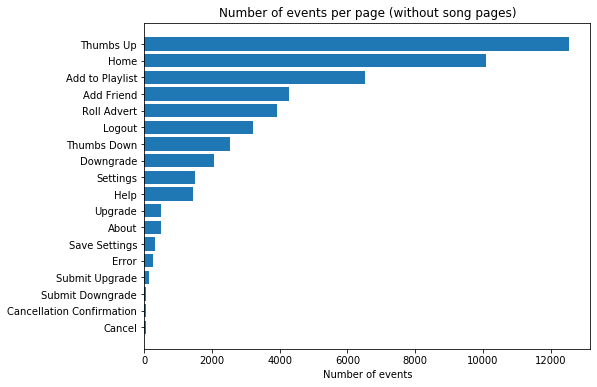

In [201]:
# Pages without 'NextSong'
num_events_per_page_nosongs = num_events_per_page[num_events_per_page.page!='NextSong']
plt.figure(figsize=(8, 6))
plt.title("Number of events per page (without song pages)")
plt.barh(num_events_per_page_nosongs['page'], num_events_per_page_nosongs['count'])
plt.xlabel("Number of events")
plt.show()

In [206]:
# We do not have the full history of users !!!
pd.to_datetime(user_log.select('registration').toPandas()['registration'], unit='ms').min()

Timestamp('2018-03-18 13:44:35')

In [215]:
num_users_per_gender

,gender,num_users
0,F,104
1,M,121


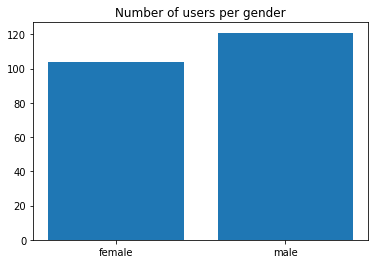

In [217]:
# Number of users per gender
num_users_per_gender = user_log.groupBy('gender').agg(F.countDistinct(F.col('userId')).alias('num_users')).toPandas()
plt.figure()
plt.title("Number of users per gender")
plt.bar(['female', 'male'], [num_users_per_gender[num_users_per_gender.gender=='F'].num_users.iloc[0],
                             num_users_per_gender[num_users_per_gender.gender=='M'].num_users.iloc[0]])
plt.show()

In [378]:
# Create date features
get_date = F.udf(lambda x: datetime.fromtimestamp(x/1000).strftime('%Y-%m-%d'), DateType())
get_hour = F.udf(lambda x: datetime.fromtimestamp(x/1000).hour, IntegerType())
get_day = F.udf(lambda x: datetime.fromtimestamp(x/1000).day, IntegerType())
get_weekday = F.udf(lambda x: datetime.fromtimestamp(x/1000).strftime('%w'), IntegerType())
get_month = F.udf(lambda x: datetime.fromtimestamp(x/1000).month, IntegerType())

d = {'date': get_date, 'hour': get_hour, 'day': get_day, 'weekday': get_weekday, 'month': get_month}

for colname, func in d.items():
    
    user_log = user_log.withColumn(colname, func('ts'))

In [379]:
# Create location features
get_city = F.udf(lambda x: x.split(', ')[0], StringType())
get_state = F.udf(lambda x: x.split(', ')[1], StringType())
user_log = user_log.withColumn('city', get_city('location'))
user_log = user_log.withColumn('state', get_state('location'))

In [244]:
user_log.select('method').dropDuplicates().show()

+------+
|method|
+------+
|   PUT|
|   GET|
+------+



In [245]:
user_log.select('level').dropDuplicates().show()

+-----+
|level|
+-----+
| free|
| paid|
+-----+



In [380]:
# Create os feature
mapper_os = {'Windows NT 6.1': 'Windows', 'Macintosh': 'Mac', 'Windows NT 6.0': 'Windows', 
             'Windows NT 6.2': 'Windows', 'iPhone': 'Mac', 'Windows NT 6.3': 'Windows', 
             'iPad': 'Mac', 'compatible': 'Windows', 'X11': 'Linux', 
             'Windows NT 5.1': 'Windows'}

get_os = F.udf(lambda x: mapper_os[ re.findall(r'\((.+?)\)', x)[0].split(';')[0] ], StringType() )
get_mobile = F.udf(lambda x: 1 if re.findall(r'\((.+?)\)', x)[0].split(';')[0] in ('iPhone', 'iPad') else 0, IntegerType() )
user_log = user_log.withColumn('os', get_os('userAgent'))
user_log = user_log.withColumn('mobile', get_mobile('userAgent'))

In [287]:
df = user_log.toPandas()

In [290]:
df.os.value_counts()

Windows    143871
Mac        125322
Linux        8961
Name: os, dtype: int64

In [283]:
df.mobile.astype('int').mean()

0.08115288653048311

In [291]:
df.status.value_counts()

200    254718
307     23184
404       252
Name: status, dtype: int64

In [511]:
user_log.toPandas().head(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId
0,Martha Tilston,Logged In,Colin,M,50,Freeman,277.89016,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Rockpools,200,1538352117000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
1,Five Iron Frenzy,Logged In,Micah,M,79,Long,236.09424,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Canada,200,1538352180000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
2,Adam Lambert,Logged In,Colin,M,51,Freeman,282.82730,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Time For Miracles,200,1538352394000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30
3,Enigma,Logged In,Micah,M,80,Long,262.71302,free,"Boston-Cambridge-Newton, MA-NH",PUT,NextSong,1.538332e+12,8,Knocking On Forbidden Doors,200,1538352416000,"""Mozilla/5.0 (Windows NT 6.1; WOW64) AppleWebK...",9
4,Daft Punk,Logged In,Colin,M,52,Freeman,223.60771,paid,"Bakersfield, CA",PUT,NextSong,1.538173e+12,29,Harder Better Faster Stronger,200,1538352676000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,30


In [381]:
# Mark churn users
user_log = user_log.withColumn('churn', F.when(F.col('page') == "Cancellation Confirmation", 1 ).otherwise(0))
window_var = Window().partitionBy('userId')
user_log = user_log.withColumn('churn', F.max(F.col('churn')).over(window_var))

In [97]:
# Is the cancellation event indeed the last events of churn users?
user_log.filter(user_log.churn == 1).orderBy('ts').groupby('userId')\
    .agg(F.last('page').alias('last_page')).select('last_page').dropDuplicates()\
    .show()

+--------------------+
|           last_page|
+--------------------+
|Cancellation Conf...|
+--------------------+



In [100]:
user_log.take(1)

[Row(artist=None, auth='Logged In', firstName='Evan', gender='M', itemInSession=0, lastName='Spencer', length=None, level='free', location='Miami-Fort Lauderdale-West Palm Beach, FL', method='GET', page='Home', registration=1537531076000, sessionId=147, song=None, status=200, ts=1538805488000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId=148, churn=0, prediction_ts=1543799476000)]

In [138]:
# Mark pre periods
ms_per_day = 86400*1000
user_log = user_log.withColumn('pre_3_days', F.when(F.col('ts').between(F.col('prediction_ts')-3*ms_per_day, F.col('prediction_ts')), 1).otherwise(0) )
user_log = user_log.withColumn('pre_7_days', F.when(F.col('ts').between(F.col('prediction_ts')-7*ms_per_day, F.col('prediction_ts')), 1).otherwise(0) )
user_log = user_log.withColumn('pre_21_days', F.when(F.col('ts').between(F.col('prediction_ts')-21*ms_per_day, F.col('prediction_ts')), 1).otherwise(0) )

In [139]:
user_log.take(1)

[Row(artist=None, auth='Logged In', firstName='Evan', gender='M', itemInSession=0, lastName='Spencer', length=None, level='free', location='Miami-Fort Lauderdale-West Palm Beach, FL', method='GET', page='Home', registration=1537531076000, sessionId=147, song=None, status=200, ts=1538805488000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId=148, churn=0, prediction_ts=1543799476000, pre_3_days=0, pre_7_days=0, pre_21_days=0)]

In [140]:
# Get days since registration
user_log = user_log.withColumn('days_since_registration', (F.col('prediction_ts') - F.col('registration')) / ms_per_day)

In [ ]:
user_log.toPandas()

In [141]:
df = user_log.toPandas()

In [134]:
df['date'] = pd.to_datetime(df['ts'], unit='ms')

In [41]:
user_log.groupBy('churn').count().show()

+-----+------+
|churn| count|
+-----+------+
|    1| 44864|
|    0|233290|
+-----+------+



In [42]:
user_log.groupBy('churn').agg(F.countDistinct('userId')).show()

+-----+-------------+
|churn|count(userId)|
+-----+-------------+
|    1|           52|
|    0|          173|
+-----+-------------+



In [ ]:
# Mark churn users
# Prediction date for churn users: last timestamp before begin of last session
# Prediction date for not churn users: last overall timestamp 

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [ ]:
# Churn users

# gender
# location
# paid
# os


# Get timestamp of last event (cancellation)
# Exclude last event
# Calculate overall event counts
# Calculate pre 3 days event counts
# Calculate pre 7 days event counts
# Calculate pre 21 days event counts
# Days since registration
# Days since downgrade
# Average length of session

# Event counts
## Sessions
## Pages
## Errors
## Artists
## Songs
## Mobile
## Durchschnittliche Zeit zwischen zwei Sessions
## Durchschnittliche Sessionlänge

In [507]:
# Read the data
path = "mini_sparkify_event_data.json"
user_log = spark.read.json(path)

In [508]:
def clean_user_log(user_log):
    """ Prepares the user log data for the feature generation process 
    
    Input:
        user_log (DataFrame) - the original user log data
        
    Output:
        DataFrame - cleansed user log data
        
    Note: The cleansing process among others involves the flagging of
    churn users and the determination of an appropriate prediction
    timestamp for each user. I provide further notes to the 
    modeling approach in the comments section.
    
    """

    # Cast userid column to integer and remove unregistered users
    user_log = user_log.withColumn("userId", user_log["userId"].cast(types.IntegerType()))
    user_log = user_log.filter(user_log.userId.isNotNull())
    
    # Flag churn events
    user_log = user_log.withColumn('churn', F.when(F.col('page') == "Cancellation Confirmation", 1 ).otherwise(0))

    # Enhance churn flags to all events of corresponding users
    window_var = Window().partitionBy('userId')
    user_log = user_log.withColumn('churn', F.max(F.col('churn')).over(window_var))
    
    # Remove cancellation events
    user_log = user_log.filter(~F.col('page').isin(["Cancellation Confirmation", "Cancel"]))
    
    # Mark date of prediction for each user
    prediction_date_nochurn = user_log.agg({'ts': 'max'}).collect()[0][0]
    user_log = user_log.withColumn('prediction_ts',\
                                   F.when(F.col('churn') == 1, F.max(F.col('ts')).over(window_var))\
                                   .otherwise(prediction_date_nochurn))
    
    return user_log

In [513]:
user_log_cleansed = clean_user_log(user_log)

In [514]:
user_log_cleansed.toPandas().head(5)

,artist,auth,firstName,gender,itemInSession,lastName,length,level,location,method,page,registration,sessionId,song,status,ts,userAgent,userId,churn,prediction_ts
0,None,Logged In,Evan,M,0,Spencer,NaN,free,"Miami-Fort Lauderdale-West Palm Beach, FL",GET,Home,1537531076000,147,None,200,1538805488000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,148,0,1543799476000
1,Blues Traveler,Logged In,Evan,M,1,Spencer,290.24608,free,"Miami-Fort Lauderdale-West Palm Beach, FL",PUT,NextSong,1537531076000,147,Hook,200,1538805521000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,148,0,1543799476000
2,Sheena Easton,Logged In,Evan,M,2,Spencer,239.62077,free,"Miami-Fort Lauderdale-West Palm Beach, FL",PUT,NextSong,1537531076000,147,Strut (1993 Digital Remaster),200,1538805811000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,148,0,1543799476000
3,Andrew Bird,Logged In,Evan,M,3,Spencer,183.48363,free,"Miami-Fort Lauderdale-West Palm Beach, FL",PUT,NextSong,1537531076000,147,Dora Goes To Town (Album Version),200,1538806050000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,148,0,1543799476000
4,Justin Bieber,Logged In,Evan,M,4,Spencer,234.91873,free,"Miami-Fort Lauderdale-West Palm Beach, FL",PUT,NextSong,1537531076000,147,Up,200,1538806233000,Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) G...,148,0,1543799476000


In [424]:
def count_events_over_time(user_log):
    """ Counts the events per user over various time periods. `Total` refers to the 
    time between registration and the prediction timestamp. `pre3`, `pre7` and `pre21`
    refer to some time before the prediction timestamp (e.g. `pre3` gives the event
    counts in the last three days before the prediction)
    
    Input:
        user_log (DataFrame) - a DataFrame containing the cleansed user log data
        
    Output:
        DataFrame - event counts per user and time period
        
    """
    
    # Create flags for relevant time periods 
    ms_per_day = 86400*1000
    user_log = user_log.withColumn('pre3', F.when(F.col('ts').between(F.col('prediction_ts')-3*ms_per_day, F.col('prediction_ts')), 1).otherwise(0) )
    user_log = user_log.withColumn('pre7', F.when(F.col('ts').between(F.col('prediction_ts')-7*ms_per_day, F.col('prediction_ts')), 1).otherwise(0) )
    user_log = user_log.withColumn('pre21', F.when(F.col('ts').between(F.col('prediction_ts')-21*ms_per_day, F.col('prediction_ts')), 1).otherwise(0) )

    # Count the number of different events per user and time period
    total = user_log.groupBy('userId').pivot('page').count()
    total = total.select(*(F.col(x).alias(x + '_total') for x in total.columns))
    pre3 = user_log.filter(F.col('pre3')==1).groupBy('userId').pivot('page').count()
    pre3 = pre3.select(*(F.col(x).alias(x + '_pre3') for x in pre3.columns))
    pre7 = user_log.filter(F.col('pre7')==1).groupBy('userId').pivot('page').count()
    pre7 = pre7.select(*(F.col(x).alias(x + '_pre7') for x in pre7.columns))
    pre21 = user_log.filter(F.col('pre21')==1).groupBy('userId').pivot('page').count()
    pre21 = pre21.select(*(F.col(x).alias(x + '_pre21') for x in pre21.columns))
    
    # Merge the results into a single dataframe
    event_counts = total.join(pre3, total.userId_total == pre3.userId_pre3, how='left')\
                    .join(pre7, total.userId_total == pre7.userId_pre7, how='left')\
                    .join(pre21, total.userId_total == pre21.userId_pre21, how='left')

    # Clean columns and fill missing values with 0
    event_counts = event_counts.withColumnRenamed('userId_total', 'userId')
    cols_to_drop = ['userId_pre3', 'userId_pre7', 'userId_pre21']
    event_counts = event_counts.drop(*cols_to_drop)
    event_counts = event_counts.na.fill(0)

    return event_counts

In [425]:
event_counts = count_events_over_time(user_log_cleansed)

In [515]:
event_counts.toPandas().head(5)

,userId,About_total,Add Friend_total,Add to Playlist_total,Downgrade_total,Error_total,Help_total,Home_total,Logout_total,NextSong_total,Roll Advert_total,Save Settings_total,Settings_total,Submit Downgrade_total,Submit Upgrade_total,Thumbs Down_total,Thumbs Up_total,Upgrade_total,About_pre3,Add Friend_pre3,Add to Playlist_pre3,Downgrade_pre3,Error_pre3,Help_pre3,Home_pre3,Logout_pre3,NextSong_pre3,Roll Advert_pre3,Save Settings_pre3,Settings_pre3,...,Error_pre7,Help_pre7,Home_pre7,Logout_pre7,NextSong_pre7,Roll Advert_pre7,Save Settings_pre7,Settings_pre7,Submit Downgrade_pre7,Submit Upgrade_pre7,Thumbs Down_pre7,Thumbs Up_pre7,Upgrade_pre7,About_pre21,Add Friend_pre21,Add to Playlist_pre21,Downgrade_pre21,Error_pre21,Help_pre21,Home_pre21,Logout_pre21,NextSong_pre21,Roll Advert_pre21,Save Settings_pre21,Settings_pre21,Submit Downgrade_pre21,Submit Upgrade_pre21,Thumbs Down_pre21,Thumbs Up_pre21,Upgrade_pre21
0,148,1,7,5,0,0,3,26,9,398,32,0,3,0,0,3,28,3,0,0,0,0,0,0,2,1,5,0,0,0,...,0,0,2,1,5,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6,3,52,4,0,0,0,0,2,4,0
1,85,6,58,108,42,2,24,157,54,3616,33,3,25,2,3,38,192,7,0,6,5,6,0,3,8,3,155,0,0,1,...,0,6,27,13,788,0,0,8,0,0,6,34,0,1,20,38,21,0,11,61,23,1519,0,2,11,0,0,12,74,0
2,137,0,8,4,0,0,1,12,5,154,10,0,1,0,1,1,8,4,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,7,2,0,0,1,11,4,113,7,0,0,0,1,1,5,4
3,65,6,53,68,20,0,13,80,21,2113,8,7,23,0,1,17,111,3,0,0,0,0,0,0,0,0,0,0,0,0,...,0,1,6,4,107,0,0,1,0,0,1,4,0,4,22,37,13,0,10,39,14,1213,2,4,11,0,0,7,57,0
4,200001,0,0,3,0,0,1,10,4,115,3,2,6,0,0,1,10,1,0,0,1,0,0,1,1,1,24,0,1,5,...,0,1,5,1,77,3,2,6,0,0,0,7,1,0,0,3,0,0,1,10,4,115,3,2,6,0,0,1,10,1


In [427]:
def get_metropolian_area_dummies(user_log):
    """ Creates dataframe with dummies for the metropolian area users are 
    living in. The information can be extracted from the `location` column in
    the user log data.
    
    Input:
        user_log (DataFrame) - a DataFrame containing the cleansed user log data
        
    Output:
        DataFrame - one hot encoded metropolian area of each user
    
    """
    
    # Create metropolian area feature
    get_state = F.udf(lambda x: x.split(', ')[1], StringType())
    user_log = user_log.withColumn('area', get_state('location'))
    
    # Get dummies and fill missing values with 0
    area_dummies = user_log.select(['userId', 'area']).dropDuplicates()\
                            .groupBy('userId').pivot('area').count()
    area_dummies = area_dummies.fillna(0)
    
    return area_dummies

In [516]:
metropolian_areas = get_metropolian_area_dummies(user_log_cleansed)

In [517]:
metropolian_areas.toPandas().head(5)

,userId,AK,AL,AR,AZ,CA,CO,CT,DC-VA-MD-WV,FL,GA,GA-AL,IA,IL,IL-IN-WI,IL-MO,IN,KY,KY-IN,LA,MA-NH,MD,MD-WV,MI,MN-WI,MO-IL,MO-KS,MS,MT,NC,NC-SC,NE-IA,NH,NJ,NV,NY,NY-NJ-PA,OH,OH-KY-IN,OK,OR,OR-WA,PA,PA-NJ,PA-NJ-DE-MD,RI-MA,SC,SC-NC,TN,TN-MS-AR,TN-VA,TX,UT,UT-ID,VA,VA-NC,WA,WI,WV
0,148,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,137,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,85,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,200001,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,65,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [429]:
def get_device_dummies(user_log):
    """ Creates dataframe with dummies for the devices each user
    uses. The information can be extracted from the `userAgent`
    column in the user log data.
    
    Input:
        user_log (DataFrame) - a DataFrame containing the cleansed user log data
        
    Output:
        DataFrame - one hot encoded devices of each user
    
    """
    
    # Create mapper for the derivation of device types
    device_mapper = {'Windows NT 6.1': 'Windows', 'Macintosh': 'Mac', 'Windows NT 6.0': 'Windows', 
                 'Windows NT 6.2': 'Windows', 'iPhone': 'iPhone', 'Windows NT 6.3': 'Windows', 
                 'iPad': 'iPad', 'compatible': 'Windows', 'X11': 'Linux', 
                 'Windows NT 5.1': 'Windows'}
    
    # Create device column 
    # Note: If device type is unknown, assign `unknown device` type
    get_device = F.udf(lambda x: device_mapper.get(re.findall(r'\((.+?)\)', x)[0].split(';')[0], 'Unknown Device'), 
                       StringType() )
    user_log = user_log.withColumn('device', get_device('userAgent'))
    
    # Get dummies and fill missing values with 0
    device_dummies = user_log.select(['userId', 'device']).dropDuplicates()\
                            .groupBy('userId').pivot('device').count()
    device_dummies = device_dummies.fillna(0)
    
    return device_dummies

In [518]:
devices = get_device_dummies(user_log_cleansed)

In [519]:
devices.toPandas().head(5)

,userId,Linux,Mac,Windows,iPad,iPhone
0,148,0,0,1,0,0
1,137,0,1,0,0,0
2,85,0,1,0,0,0
3,65,1,0,0,0,0
4,200001,0,0,1,0,0


In [521]:
def calculate_session_length(user_log):
    """ Calculates the average length of all sessions of a user 
    
    Input:
        user_log (DataFrame) - a DataFrame containing the cleansed user log data
        
    Output:
        DataFrame - average session length per user
    
    """

    # Calculate length per session
    session_length = user_log.groupBy(['userId', 'sessionId'])\
                             .agg((F.max('ts')-F.min('ts')).alias('session_length'))
    
    # Calculate average length of all sessions per user
    avg_session_length = session_length.groupBy('userId')\
                                       .agg((F.mean('session_length')/60000).alias('Length Per Session'))
    
    return avg_session_length

In [522]:
session_length = calculate_session_length(user_log_cleansed)

In [523]:
session_length.toPandas().head(5)

,userId,Length Per Session
0,148,132.355556
1,85,370.846341
2,137,211.261111
3,200001,83.508333
4,65,384.174638


In [ ]:
def calculate_time_between_sessions(user_log):
    
    pass

In [493]:
def get_current_level(user_log):
    """ Gets the current level of each user
    
    Input:
        user_log (DataFrame) - a DataFrame containing the cleansed user log data
        
    Output:
        DataFrame - current level per user (0=unpaid, 1=paid)
    
    """
    
    # Get payment mode of last event of users
    window_var = Window().partitionBy('userId').orderBy(F.desc('ts'))
    current_level = user_log.withColumn('rn', F.row_number().over(window_var))\
                           .filter(F.col('rn')==1).select(['userId', 'level'])
    
    # Make binary feature (0=unpaid, 1=paid)
    is_user_paying = F.udf(lambda x: 1 if x=="paid" else 0)
    current_level = current_level.withColumn('level', is_user_paying('level'))
    current_level = current_level.withColumnRenamed('level', 'Paying')
    
    return current_level

In [524]:
current_level = get_current_level(user_log_cleansed)

In [525]:
current_level.toPandas().head(5)

,userId,Paying
0,148,0
1,85,1
2,137,1
3,65,1
4,200001,0


In [475]:
def count_number_of_paid_days()

Signature: F.row_number()
Docstring:
Window function: returns a sequential number starting at 1 within a window partition.

.. versionadded:: 1.6
File:      /opt/anaconda3/lib/python3.7/site-packages/pyspark/sql/functions.py
Type:      function


In [ ]:
number of paid days

In [ ]:
gender

In [ ]:
days since registration

In [ ]:
## features that i ignore because of possible missing values

time between sessions

In [418]:
user_log.groupby('userId').agg(F.countDistinct(F.col('os'))).toPandas().mean()

userId       65391.013333
count(os)        1.000000
dtype: float64

In [323]:
user_log.filter(F.col('status').isin(404)).select('page').dropDuplicates().show()

+-----+
| page|
+-----+
|Error|
+-----+



In [321]:
user_log.filter((F.col('page')=='Logout')).select('status').dropDuplicates().toPandas()

,status
0,307


# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.